## Data import and exploration

For this example, I am using the wine classification dataset from scikit-learn to perform the classification task. The dataset serves as a good toy set example to evaluate the clustering algorithms on 3+ classes

In [87]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler    # To apply z-score normalization on the dataset
import numpy as np
import pandas as pd

wine_dataset = load_wine()                          # Return a bunch object that has the attributes - data, target, feature names and target names
data, labels = wine_dataset.data, wine_dataset.target
(num_sample, num_feature) = data.shape
num_label = np.unique(labels).size
feature_names = wine_dataset.feature_names

feature_df = pd.DataFrame(data,columns=feature_names)
label_df = pd.DataFrame(labels, columns=['class'])

print(f"There are {num_sample} samples, each having {num_feature} feature(s) and belong to one of {num_label} types")


There are 178 samples, each having 13 feature(s) and belong to one of 3 types


### Explore some samples in the dataset

In [ ]:
feature_df.head(10)

## Data Processing

In [ ]:
# Check if there is any missing value in the dataset
print("Missing values in any column of the dataset? \n")
print(pd.isnull(feature_df).any())

In the code block below, I am applying a z-score normalizer on the feature dataframe

In [88]:
scaler = StandardScaler()
feature_df_normalized = pd.DataFrame(scaler.fit_transform(feature_df),columns=feature_names)

In [95]:
data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

## KMeans Clustering

In [171]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.stats import mode

kmeans = KMeans(
    n_clusters=3,
    init='random',
    n_init=20,
    max_iter=300,
    random_state=42  # for reproducibility
)

# Fit the model to the normalized data
kmeans.fit(feature_df_normalized)

# Find the most frequent true label in each cluster
new_labels = np.zeros_like(kmeans.labels_)
for i in range(3):
    # Get the indices of samples assigned to cluster i
    cluster_samples = np.where(kmeans.labels_ == i)[0]
    # Get the most frequent ground truth label for these samples
    most_common_label = mode(labels[cluster_samples])[0]  # true_labels should be the actual ground truth labels
    # Assign the most common label to all points in this cluster
    new_labels[cluster_samples] = most_common_label

In [183]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.stats import mode

# Set up parameter grid for KMean experiment
param_grid = {
    'n_clusters': [2, 3, 4, 5],         # Number of clusters
    'init': ['k-means++', 'random'],    # Initialization method
    'n_init': [5, 10, 15, 20],                 # Number of initializations
    'max_iter': [50, 100, 200, 300],             # Maximum iterations
}

# Store results
results = []

# Iterate through each combination of parameter in the grid and perform KMean Clustering
for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                # Initialize the KMeans object with the current parameters
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42  # for reproducibility
                )
                
                # Fit the model to the normalized data
                kmeans.fit(feature_df_normalized)

                # Evaluate the model using silhouette score (measuring how well the clustering was done)
                silhouette_avg = silhouette_score(feature_df_normalized, kmeans.labels_)
                
                # Store the results
                results.append({
                    'n_clusters': n_clusters,
                    'init': init,
                    'n_init': n_init,
                    'max_iter': max_iter,
                    'silhouette_score': silhouette_avg,
                })

In [184]:
# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Print out the top results with the highest silhouette score
num_top_results = 9
top_results = results_df.sort_values(by='silhouette_score', ascending=False).head(num_top_results)

print(f"The silhouette score of the top {num_top_results} results")
top_results

The silhouette score of the top 9 results


,n_clusters,init,n_init,max_iter,silhouette_score
63,3,random,20,300,0.284859
62,3,random,20,200,0.284859
61,3,random,20,100,0.284859
60,3,random,20,50,0.284859
59,3,random,15,300,0.284859
58,3,random,15,200,0.284859
57,3,random,15,100,0.284859
56,3,random,15,50,0.284859
55,3,random,10,300,0.284859


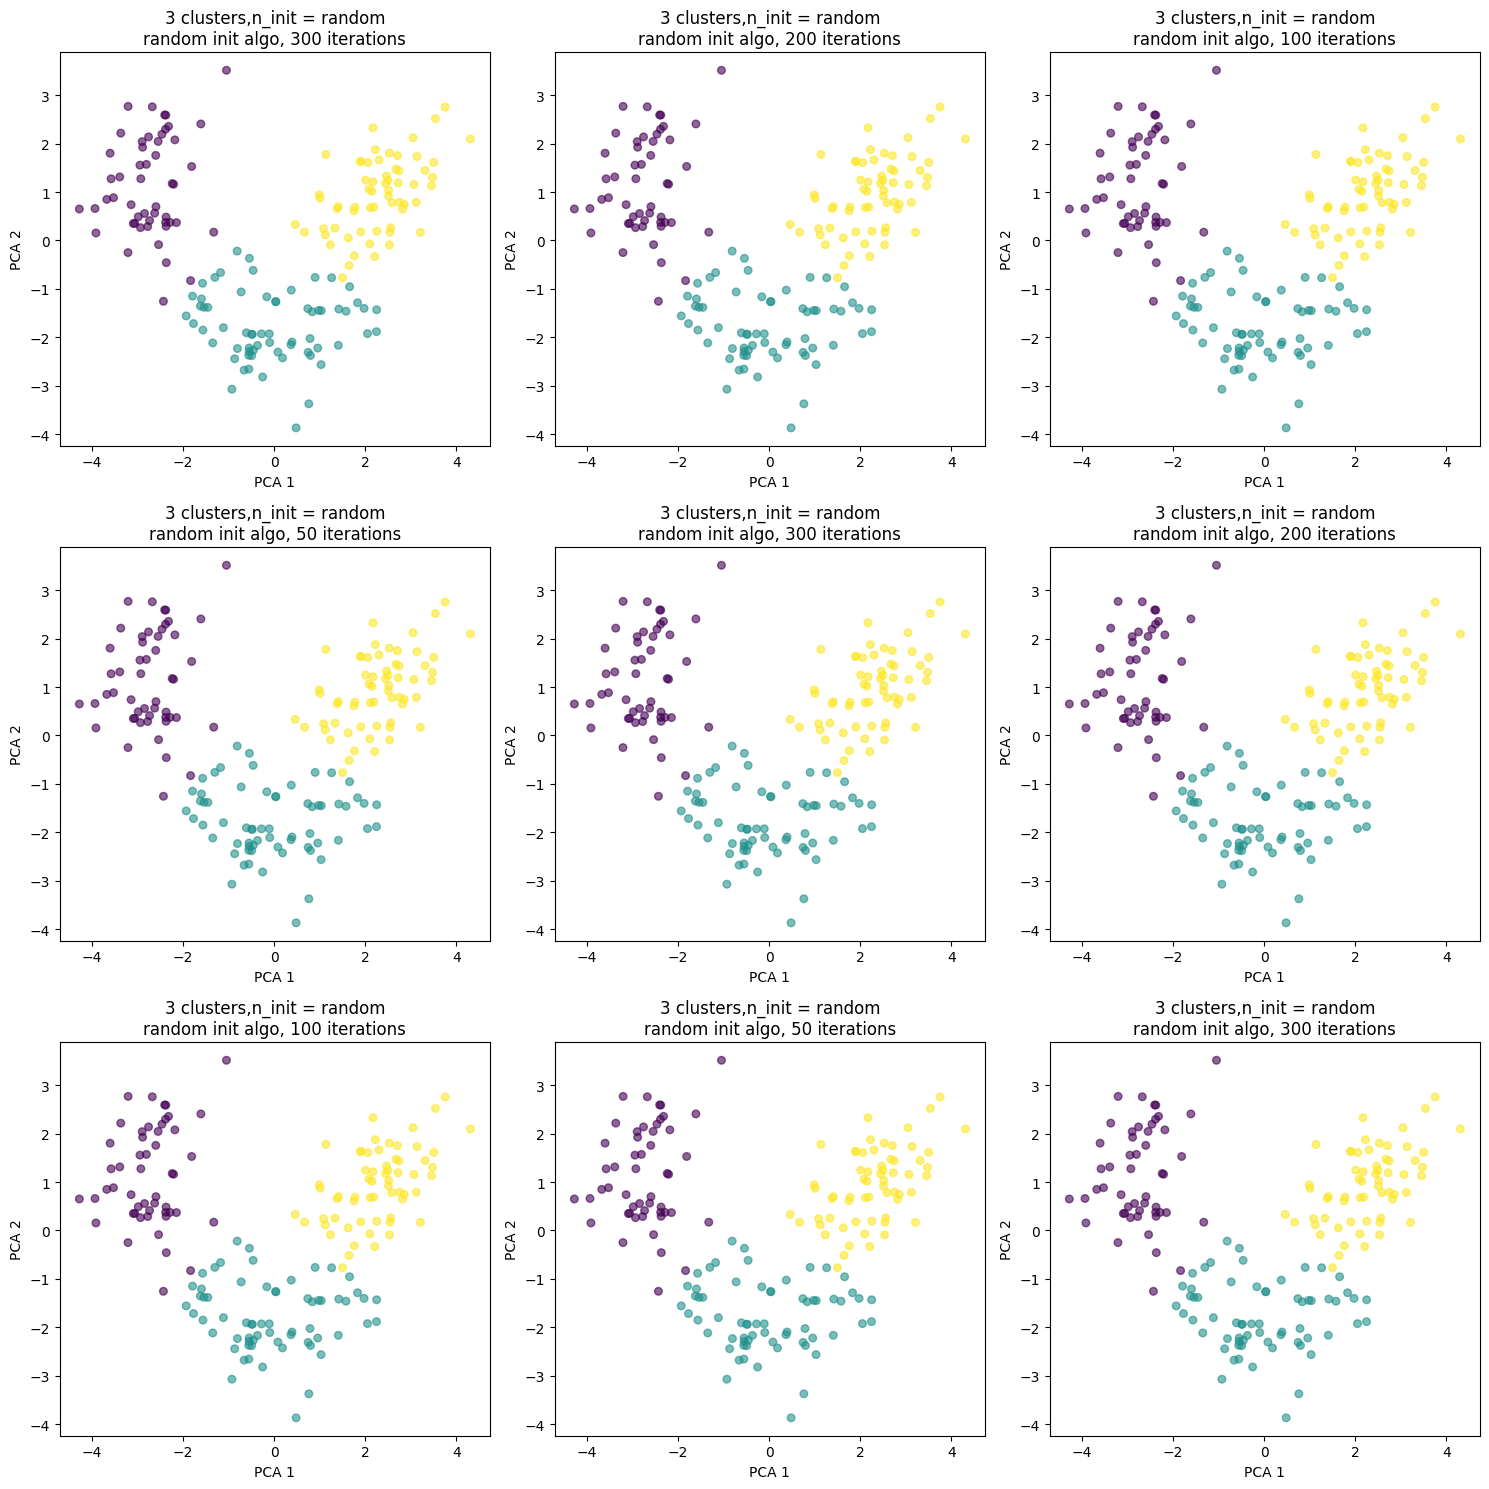

In [185]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import pandas as pd

# Load the dataset
data, labels = load_wine(return_X_y=True)
data = StandardScaler().fit_transform(data)  # Normalize the data (Z-score)

# Set up a plotting grid
num_rows = 3; num_cols = int(num_top_results / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# For each of the top 5 combinations, perform KMeans and visualize
for i, param_set in enumerate(top_results.itertuples()):
    row = i // 3
    col = i % 3
    # Extract the parameters for the KMeans model
    kmeans = KMeans(
        n_clusters=param_set.n_clusters,
        init=param_set.init,
        n_init=param_set.n_init,
        max_iter=param_set.max_iter,
        random_state=42
    )
    
    # Fit the KMeans model
    kmeans.fit(data)
    
    # Reduce the dimensions of the data to 2D using PCA or t-SNE
    # You can choose either PCA or t-SNE, depending on your preference
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    # Alternatively, use t-SNE for a more flexible, non-linear approach:
    # tsne = TSNE(n_components=2, random_state=42)
    # reduced_data = tsne.fit_transform(data)\

    # Plot the clusters
    axes[row,col].scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=30, alpha=0.6)
    axes[row,col].set_title(f"{param_set.n_clusters} clusters,"
                      f"n_init = {param_set.init}\n"
                      f"{param_set.init} init algo, "
                      f"{param_set.max_iter} iterations")
    axes[row,col].set_xlabel('PCA 1')
    axes[row,col].set_ylabel('PCA 2')

# Show the plot
plt.tight_layout()
plt.show()


## Agglomerative Clustering

## Comparison and Analysis